In [1]:
import math
import os
import sys
sys.path.insert(0,'../src/')
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from database import SQLiteDatabase
from experiment import preliminary_setup

In [2]:
KWARGS = preliminary_setup()
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
register_matplotlib_converters()
DB_DIRECTORY = KWARGS['database_directory']
FIGURES_DIRECTORY = KWARGS['figure_directory']
DATABASE = SQLiteDatabase(os.path.join(DB_DIRECTORY,'reward_design.db'))
GRID = DATABASE.get_table('grid')
SIMULATION_IDS = GRID['simulation_id'].unique()

# Cummulative reward trajectory

In [4]:
print(DATABASE.get_schema())

CREATE TABLE grid (
        carbon_emission_exponent REAL,electricity_price_exponent REAL,electricity_price_weight REAL,type TEXT,simulation_group REAL,seed REAL,buildings TEXT,simulation_id TEXT,
        PRIMARY KEY (simulation_id)
    )

CREATE TABLE detailed_summary (
        timestamp TEXT,
        time_step INTEGER,
        simulation_id TEXT,
        episode INTEGER,
        building_id INTEGER,
        building_name TEXT,
        net_electricity_consumption REAL,
        net_electricity_consumption_emission REAL,
        net_electricity_consumption_price REAL,
        net_electricity_consumption_without_storage REAL,
        net_electricity_consumption_emission_without_storage REAL,
        net_electricity_consumption_price_without_storage REAL,
        net_electricity_consumption_without_storage_and_pv REAL,
        electrical_storage_soc REAL,
        electrical_storage_electricity_consumption REAL,
        reward REAL,
        PRIMARY KEY (simulation_id, episode, time_step, b

In [7]:
query = f"""
SELECT
    g.simulation_group,
    s.episode,
    s.building_id,
    MAX(g.carbon_emission_exponent) AS carbon_emission_exponent,
    MAX(g.electricity_price_exponent) AS electricity_price_exponent,
    1.0 - MAX(g.electricity_price_weight) AS carbon_emission_weight,
    MAX(g.electricity_price_weight) AS electricity_price_weight,
    AVG(s.value) AS value
FROM (
    SELECT
        s.simulation_id,
        s.episode,
        s.building_id,
        SUM(s.reward) AS value
    FROM detailed_summary s
    GROUP BY
        s.simulation_id,
        s.episode,
        s.building_id
) s
LEFT JOIN grid g ON g.simulation_id = s.simulation_id
GROUP BY
    g.simulation_group,
    s.episode,
    s.building_id
"""
reward_data = DATABASE.query_table(query)

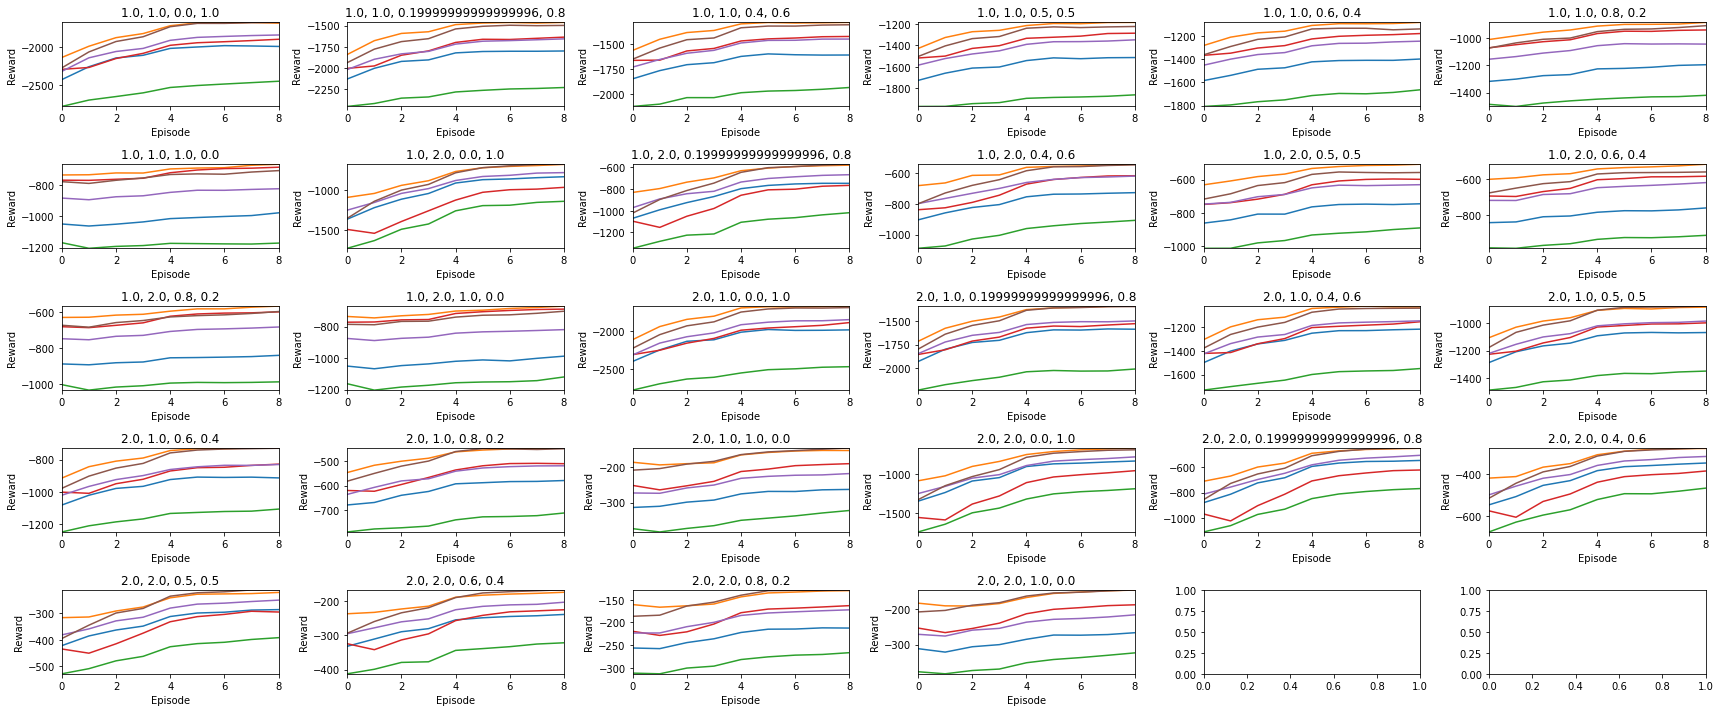

In [9]:
column_count_limit = 6
simulation_group_count = len(reward_data['simulation_group'].unique())
row_count = math.ceil(simulation_group_count/column_count_limit)
column_count = min(simulation_group_count, column_count_limit)
fig, _ = plt.subplots(row_count, column_count, figsize=(4*column_count, 2*row_count))
groupby_columns = ['electricity_price_weight', 'carbon_emission_weight', 'electricity_price_exponent', 'carbon_emission_exponent',]

for i, (ax, ((p_w, e_w, p_e, e_e), s_data)) in enumerate(zip(fig.axes, reward_data.groupby(groupby_columns))):
    for b, b_data in s_data.groupby('building_id'):
        x, y = b_data['episode'], b_data['value']
        ax.plot(x, y, label=b)

    ax.set_title(f'w1: {p_w}, w2: {e_w}, e1: {p_e}, e2: {e_e}')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Reward')

plt.tight_layout()
plt.show()

# Electricity price and carbon emission costs

In [11]:
query = f"""
WITH carbon_emission AS (
    SELECT
        d.simulation_id,
        d.episode,
        d.building_id,
        SUM(MAX(0, d.net_electricity_consumption_emission))/SUM(MAX(0, d.net_electricity_consumption_emission_without_storage)) AS value
    FROM detailed_summary d
    GROUP BY
        d.simulation_id,
        d.episode,
        d.building_id
), price AS (
    SELECT
        d.simulation_id,
        d.episode,
        d.building_id,
        SUM(MAX(0, d.net_electricity_consumption_price))/SUM(MAX(0, d.net_electricity_consumption_price_without_storage)) AS value
    FROM detailed_summary d
    GROUP BY
        d.simulation_id,
        d.episode,
        d.building_id
)

SELECT
    g.simulation_group,
    g.carbon_emission_exponent,
    g.electricity_price_exponent,
    1.0 - g.electricity_price_weight AS carbon_emission_weight,
    g.electricity_price_weight,
    c.episode,
    c.building_id,
    AVG(c.value) AS carbon_emission,
    AVG(p.value) AS price,
    (AVG(c.value) + AVG(p.value))/2.0 AS average_score
FROM grid g
LEFT JOIN carbon_emission c ON c.simulation_id = g.simulation_id
LEFT JOIN price p ON p.episode = c.episode AND p.building_id = c.building_id AND p.simulation_id = c.simulation_id
GROUP BY
    g.simulation_group,
    g.carbon_emission_exponent,
    g.electricity_price_exponent,
    g.electricity_price_weight,
    c.episode,
    c.building_id
"""
building_cost_data = DATABASE.query_table(query)
district_cost_data = building_cost_data.groupby([
    'simulation_group', 
    'carbon_emission_exponent', 
    'electricity_price_exponent', 
    'carbon_emission_weight', 
    'electricity_price_weight',
    'episode'
])[['carbon_emission','price','average_score']].mean().reset_index()